In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

import peascription_work, peatrain_work, peapredict_count # These files are copied from the original ones with some small modifications

# Showing values in pandas objects to three decimal places
pd.options.display.float_format = '{:.3f}'.format

In [2]:
def annotations_srs(seed_no, desired_sample_size, all_annotation_images_list):
    """This function is to perform the Simple Random Sampling method"""
    
    rng = np.random.default_rng(seed = seed_no)
    annotations_indexes_to_sample = rng.choice(a = range(len(all_annotation_images_list)),
                                               replace = False,
                                               size = desired_sample_size)
    annotation_images_to_sample = np.array(all_annotation_images_list)[annotations_indexes_to_sample]

    return list(annotation_images_to_sample)

In [3]:
def annotations_syss(seed_no, all_annotation_images_list, desired_sample_size):
    """This function is to perform the Systematic Sampling method"""
    
    sampling_interval = len(all_annotation_images_list) // desired_sample_size
    rng = np.random.default_rng(seed = seed_no)
    sampling_starting_point = rng.choice(a = range(sampling_interval))
    annotations_indexes_to_sample = range(sampling_starting_point, 
                                          len(all_annotation_images_list),
                                          sampling_interval)
    annotation_images_to_sample = np.array(all_annotation_images_list)[annotations_indexes_to_sample]

    return list(annotation_images_to_sample)

In [4]:
def annotations_sampling_with_specific_pnp_ratio(seed_no, plant_annotations, not_plant_annotations, desired_sample_size, plant_ratio):
    """This function is to perform sampling under a specific P:NP ratio"""

    rng = np.random.default_rng(seed = seed_no)
    plant_annotations_indexes_to_sample = rng.choice(a = range(len(plant_annotations)),
                                                     replace = False,
                                                     size = round(plant_ratio * desired_sample_size))
    plant_annotation_images_to_sample = np.array(plant_annotations)[plant_annotations_indexes_to_sample]

    rng = np.random.default_rng(seed = seed_no)
    not_plant_annotations_indexes_to_sample = rng.choice(a = range(len(not_plant_annotations)),
                                                         replace = False,
                                                         size = round((1 - plant_ratio) * desired_sample_size))
    not_plant_annotation_images_to_sample = np.array(not_plant_annotations)[not_plant_annotations_indexes_to_sample]
    
    annotation_images_to_sample = list(plant_annotation_images_to_sample) + list(not_plant_annotation_images_to_sample)
    return annotation_images_to_sample

In [5]:
def copy_selected_annot_images_to_sample_dir(images_sampled_dir, plant_images_dir, not_plant_images_dir, images_to_sample):
    """This function is to copy the annotations selected by sampling from the 'images' directory to another directory """

    # Empty the sample directory every time a new simulation run is performed
    shutil.rmtree(path = images_sampled_dir, ignore_errors = True)

    # Create two folders of plants and not-plants in the sample directory
    plant_annotation_images_sampled_dir = os.path.join(images_sampled_dir, "plant/")
    not_plant_annotation_images_sampled_dir = os.path.join(images_sampled_dir, "not_plant/")
    os.makedirs(name = plant_annotation_images_sampled_dir, exist_ok = True)
    os.makedirs(name = not_plant_annotation_images_sampled_dir, exist_ok = True)

    for image_path in images_to_sample:
        if image_path in os.listdir(plant_images_dir):
            shutil.copy2(src = os.path.join(plant_images_dir, image_path), 
                         dst = os.path.join(plant_annotation_images_sampled_dir, image_path))
        elif image_path in os.listdir(not_plant_images_dir):
            shutil.copy2(src = os.path.join(not_plant_images_dir, image_path), 
                         dst = os.path.join(not_plant_annotation_images_sampled_dir, image_path))

In [6]:
def set_up_for_peascription_on_each_test_plot(test_plots_dir, test_plot):
    """This function is to put a test plot and its corresponding red-dotted image into a directory from 
    which peascription.py can be run to extract the plant and not-plants cutouts from that particular image"""

    current_test_plot_dir = os.path.join(test_plots_dir, "current_test_plot/")
    shutil.rmtree(path = current_test_plot_dir, ignore_errors = True)
    os.makedirs(current_test_plot_dir, exist_ok = True)
    current_test_plot_dot_filepath = test_plots_dir + "dot_plots/" + test_plot.split("-")[0] + "-dot.png"
    shutil.copy2(src = os.path.join(test_plots_dir, test_plot), dst = current_test_plot_dir)
    shutil.copy2(src = current_test_plot_dot_filepath, dst = current_test_plot_dir)

    return current_test_plot_dir

In [7]:
def count_plants_from_square_cutouts(current_plot_dir):
    """After the cutouts from a test plots are collected, get peapredict.py to run through every 
    single one of them, then return the total model-made plant count for that particular test plot"""

    current_plot_plant_dir = current_plot_dir + "plant/"
    plant_count_from_plant_dir = peapredict_count.run(square_cutouts_dir = current_plot_plant_dir)

    current_plot_not_plant_dir = current_plot_dir + "not_plant/"
    plant_count_from_not_plant_dir = peapredict_count.run(square_cutouts_dir = current_plot_not_plant_dir)

    return plant_count_from_plant_dir + plant_count_from_not_plant_dir

In [8]:
def plant_count_rmse_calc(test_plots_directory):
    """From the model-made plant count, prediction errors for each individual test plot can be obtained by
    by comparing that model-made count with the manual count (which is the length of the plant directory generated
    by peascription.py). Multiple prediction errors will then be condensed into a signle RMSE score."""

    test_plots_plant_count_df = pd.DataFrame({'test_plot': [], 'model-made plant count': [], 'manual plant count': []})
    for test_plot_filename in [item for item in os.listdir(test_plots_directory) if item.endswith(".png")]:
        current_test_plot_dir = set_up_for_peascription_on_each_test_plot(
            test_plots_dir = test_plots_directory, test_plot = test_plot_filename)

        peascription_work.run(in_dir_path = current_test_plot_dir, out_dir_path = current_test_plot_dir)

        current_test_plot_model_made_plant_count = count_plants_from_square_cutouts(current_test_plot_dir)

        test_plots_plant_count_df.loc[len(test_plots_plant_count_df)] = [
            test_plot_filename,
            current_test_plot_model_made_plant_count,
            len(os.listdir(os.path.join(current_test_plot_dir, "plant/")))]
        
    plant_count_rmse = mean_squared_error(
        y_true = test_plots_plant_count_df['manual plant count'],
        y_pred = test_plots_plant_count_df['model-made plant count'],
        squared = False)
    
    return plant_count_rmse

In [9]:
# Specifying some global variables
plant_annotation_images_dir = "images/plant/"
not_plant_annotation_images_dir = "images/not_plant/"
all_annotation_images = os.listdir(plant_annotation_images_dir) + os.listdir(not_plant_annotation_images_dir)
annot_images_sampled_dir = "annot_images_sampled"
test_plots_dir = "test_plots/Day3/"
training_sample_size = 100 # For the current experiments, the sample size is set to be 100

## 1. Simple Random Sampling

In [ ]:
srs_250_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})

# The decision on this simulation length is delineated below
for seed in range(250): 
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")

    # Performing the Simple Random Sampling to get which annotations to be sampled
    annotation_images_to_be_sampled = annotations_srs(seed_no = seed, desired_sample_size = training_sample_size,
                                                      all_annotation_images_list = all_annotation_images)

    # Copy the selected annotations to a separate folder so that peatrain.py can be run through them
    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
    
    # Train a model with the sampled annotations
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
    
    # Computing the plant-count RMSE that the trained model returns on the test plots
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    # Update the simulation records
    srs_250_iter_record_df.loc[len(srs_250_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]

In [12]:
# Export the simulation records to a CSV file for use later
srs_250_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/srs_250_iter_record.csv", index = False)
srs_250_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,0.0,11.0,1.00,67.612129
1,1.0,35.0,1.00,21.756225
2,2.0,35.0,1.00,30.110906
3,3.0,15.0,1.00,27.684532
4,4.0,6.0,0.90,132.239807
...,...,...,...,...
245,245.0,13.0,1.00,47.554180
246,246.0,5.0,0.90,6.992853
247,247.0,10.0,1.00,30.462545
248,248.0,13.0,1.00,17.193022


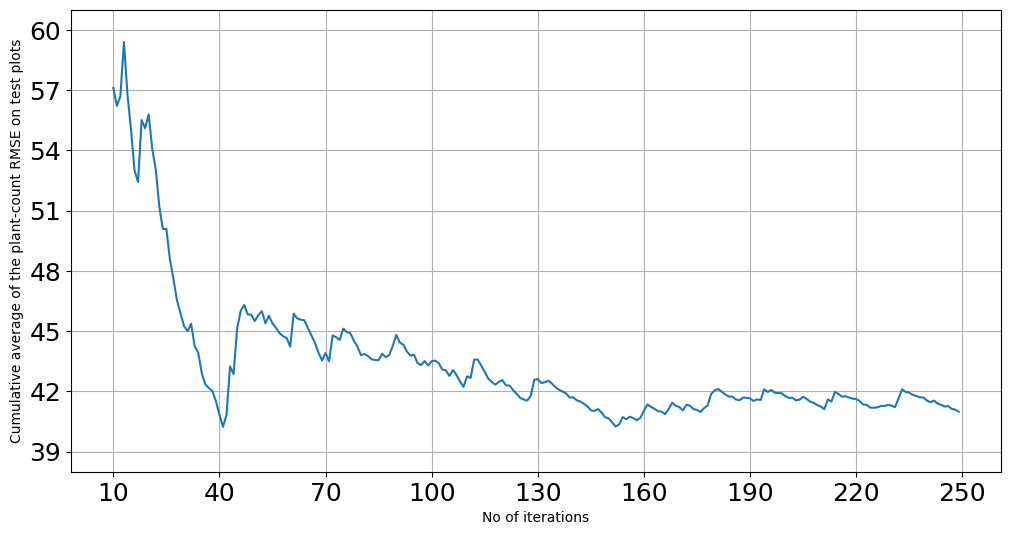

In [14]:
# Obtain the cumulative RMSE averages as the number of iterations is incremented to identify the point of convergence
# (During the progress of this project, the simulation length started with a low number, then it kept being incremented ...
# ... until an approopriate point of convergence can be found in the cumulative plant-count RMSE averages)
srs_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 250, 1):
    mean_of_test_RMSEs = srs_250_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    srs_cumulative_mean_test_RMSEs_df.loc[len(srs_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

srs_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative average of the plant-count RMSE on test plots")
plt.xticks(range(10, 251, 30), fontsize=18)
plt.yticks(range(39, 62, 3), fontsize=18)
plt.ylim(38,61)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

## 2. Systematic sampling

In [ ]:
sys_s_450_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})

# The decision on this simulation length is delineated below
for seed in range(0,450):
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")

    # Performing the Systematic Sampling to get which annotations to be sampled
    annotation_images_to_be_sampled = annotations_syss(
        seed_no = seed, all_annotation_images_list = all_annotation_images, desired_sample_size = training_sample_size)

    # Copy the selected annotations to a separate folder so that peatrain.py can be run through them
    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
     
    # Train a model with the sampled annotations
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
        
    # Computing the plant-count RMSE that the trained model returns on the test plots
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    # Update the simulation records
    sys_s_450_iter_record_df.loc[len(sys_s_450_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]


In [15]:
# Export the simulation records to a CSV file for use later
sys_s_450_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/sys_s_450_iter_record.csv", index = False)
sys_s_450_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,0.0,33.0,1.00,44.564186
1,1.0,27.0,1.00,35.152525
2,2.0,15.0,1.00,32.981308
3,3.0,17.0,1.00,29.965536
4,4.0,26.0,1.00,54.160564
...,...,...,...,...
445,445.0,14.0,0.95,24.413794
446,446.0,34.0,1.00,35.647814
447,447.0,17.0,1.00,33.506716
448,448.0,22.0,0.90,40.369543


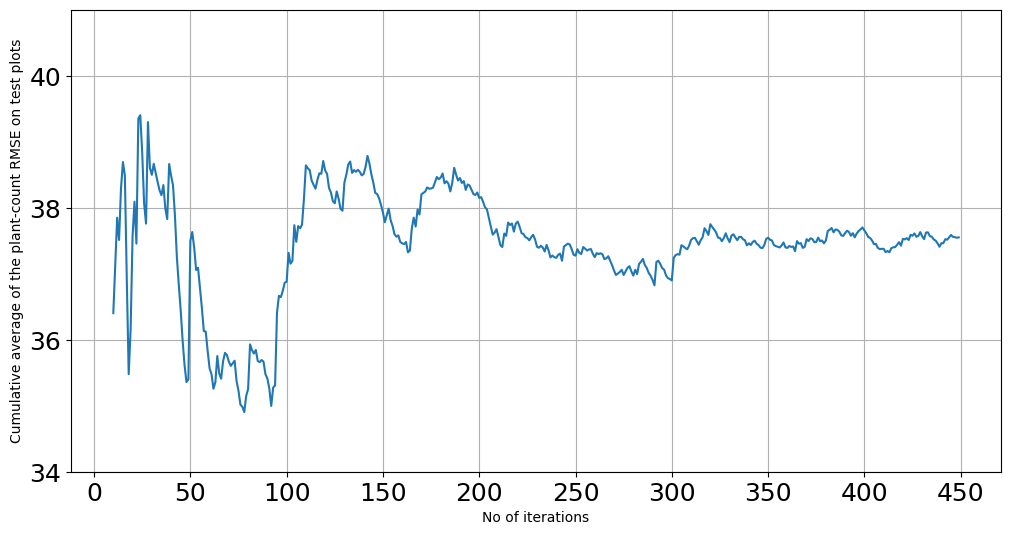

In [17]:
# Obtain the cumulative RMSE averages as the number of iterations is incremented to identify the point of convergence
sys_s_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 450, 1):
    mean_of_test_RMSEs = sys_s_450_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    sys_s_cumulative_mean_test_RMSEs_df.loc[len(sys_s_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

sys_s_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative average of the plant-count RMSE on test plots")
plt.xticks(range(0,451,50), fontsize = 18)
plt.yticks(range(34,41,2), fontsize = 18)
plt.ylim(34, 41)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

## 3. Sampling with a specific P:NP ratio

#### a. (Plant / Not_plant) ratio = 50:50 (D)

In [ ]:
p50_np50_sampling_310_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})
for seed in range(310):
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")
    annotation_images_to_be_sampled = annotations_sampling_with_specific_pnp_ratio(
        seed_no = seed, plant_annotations = os.listdir(plant_annotation_images_dir), 
        not_plant_annotations = os.listdir(not_plant_annotation_images_dir), 
        desired_sample_size = training_sample_size, plant_ratio = 0.5)

    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
     
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
        
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    p50_np50_sampling_310_iter_record_df.loc[len(p50_np50_sampling_310_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]


In [18]:
p50_np50_sampling_310_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/p50_np50_sampling_310_iter_record.csv", index = False)
# p50_np50_sampling_310_iter_record_df = pd.read_csv("sampling_outputs/ss100/p50_np50_sampling_310_iter_record.csv")
p50_np50_sampling_310_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,0.0,14.0,0.85,44.395195
1,1.0,6.0,1.00,4.041452
2,2.0,28.0,1.00,19.517514
3,3.0,7.0,0.95,16.604216
4,4.0,20.0,1.00,4.143268
...,...,...,...,...
305,305.0,12.0,1.00,21.899011
306,306.0,30.0,1.00,18.542743
307,307.0,8.0,1.00,26.657082
308,308.0,5.0,0.95,27.067816


In [19]:
p50_np50_sampling_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 311, 1):
    mean_of_test_RMSEs = p50_np50_sampling_310_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    p50_np50_sampling_cumulative_mean_test_RMSEs_df.loc[len(p50_np50_sampling_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

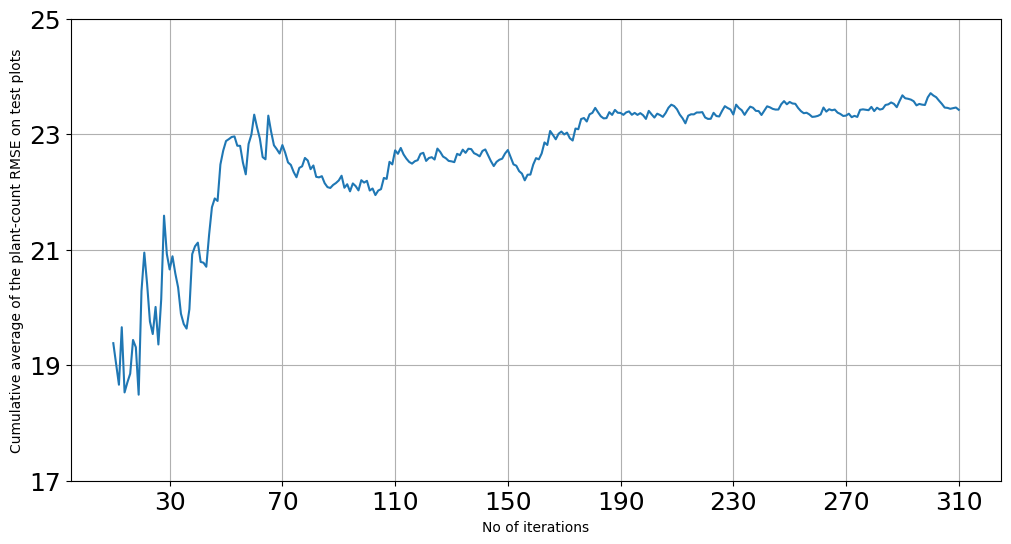

In [20]:
p50_np50_sampling_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative average of the plant-count RMSE on test plots")
plt.xticks(range(30,311,40), fontsize = 18)
plt.yticks(range(17,26,2), fontsize = 18)
plt.ylim(17, 25)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

#### b. (Plant / Not_plant) ratio = 60:40 (D)

In [ ]:
p60_np40_sampling_500_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})
for seed in range(500):
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")
    annotation_images_to_be_sampled = annotations_sampling_with_specific_pnp_ratio(
        seed_no = seed, plant_annotations = os.listdir(plant_annotation_images_dir), 
        not_plant_annotations = os.listdir(not_plant_annotation_images_dir), 
        desired_sample_size = training_sample_size, plant_ratio = 0.6)

    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
    
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
        
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    p60_np40_sampling_500_iter_record_df.loc[len(p60_np40_sampling_500_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]


In [17]:
p60_np40_sampling_500_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/p60_np40_sampling_500_iter_record.csv", index = False)
# p60_np40_sampling_500_iter_record_df = pd.read_csv("sampling_outputs/ss100/p60_np40_sampling_500_iter_record.csv")
p60_np40_sampling_500_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,0.0,15.0,1.00,9.485076
1,1.0,33.0,0.90,28.511986
2,2.0,7.0,1.00,7.009517
3,3.0,24.0,1.00,4.546061
4,4.0,2.0,0.95,75.781484
...,...,...,...,...
25,495.0,16.0,1.00,8.542053
26,496.0,26.0,1.00,38.681175
27,497.0,24.0,1.00,10.069757
28,498.0,23.0,1.00,30.268796


In [18]:
p60_np40_sampling_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 501, 1):
    mean_of_test_RMSEs = p60_np40_sampling_500_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    p60_np40_sampling_cumulative_mean_test_RMSEs_df.loc[len(p60_np40_sampling_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

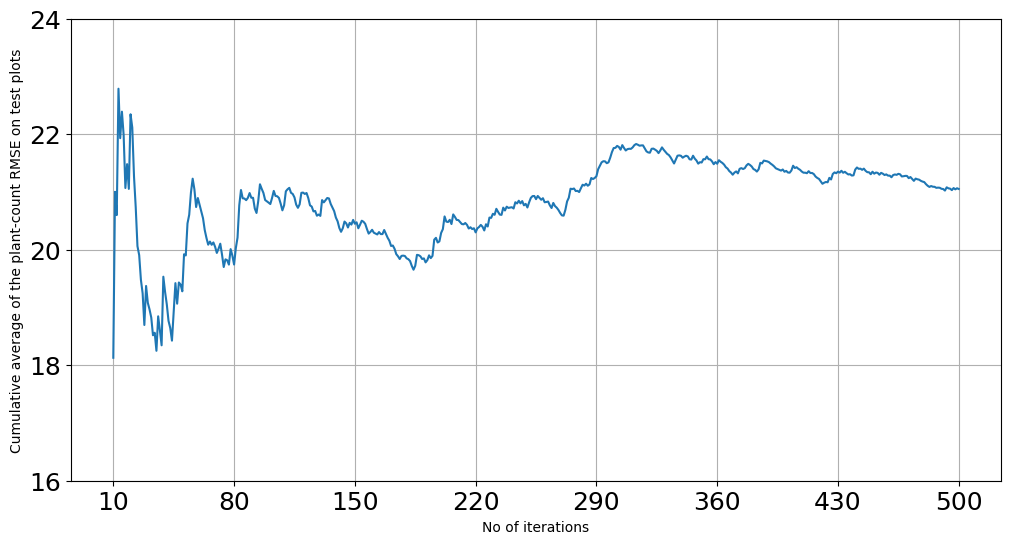

In [22]:
p60_np40_sampling_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative average of the plant-count RMSE on test plots")
plt.xticks(range(10,501,70), fontsize = 18)
plt.yticks(range(16,25,2), fontsize = 18)
plt.ylim(16, 24)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

#### c. (Plant / Not_plant) ratio = 70:30 (D)

In [ ]:
p70_np30_sampling_300_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})
for seed in range(300):
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")
    annotation_images_to_be_sampled = annotations_sampling_with_specific_pnp_ratio(
        seed_no = seed, plant_annotations = os.listdir(plant_annotation_images_dir), 
        not_plant_annotations = os.listdir(not_plant_annotation_images_dir), 
        desired_sample_size = training_sample_size, plant_ratio = 0.7)

    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
     
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
        
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    p70_np30_sampling_300_iter_record_df.loc[len(p70_np30_sampling_300_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]


In [12]:
p70_np30_sampling_300_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/p70_np30_sampling_300_iter_record.csv", index = False)
# p70_np30_sampling_300_iter_record_df = pd.read_csv("sampling_outputs/ss100/p70_np30_sampling_300_iter_record.csv")
p70_np30_sampling_300_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,320.0,26.0,1.00,10.406729
1,321.0,3.0,1.00,31.428755
2,322.0,18.0,1.00,4.986649
3,323.0,2.0,0.60,28.811456
4,324.0,39.0,1.00,5.218557
5,325.0,19.0,1.00,23.665728
6,326.0,22.0,1.00,3.781534
7,327.0,10.0,1.00,4.647580
8,328.0,50.0,1.00,7.646350
9,329.0,5.0,0.95,33.800394


In [76]:
p70_np30_sampling_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 301, 1):
    mean_of_test_RMSEs = p70_np30_sampling_300_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    p70_np30_sampling_cumulative_mean_test_RMSEs_df.loc[len(p70_np30_sampling_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

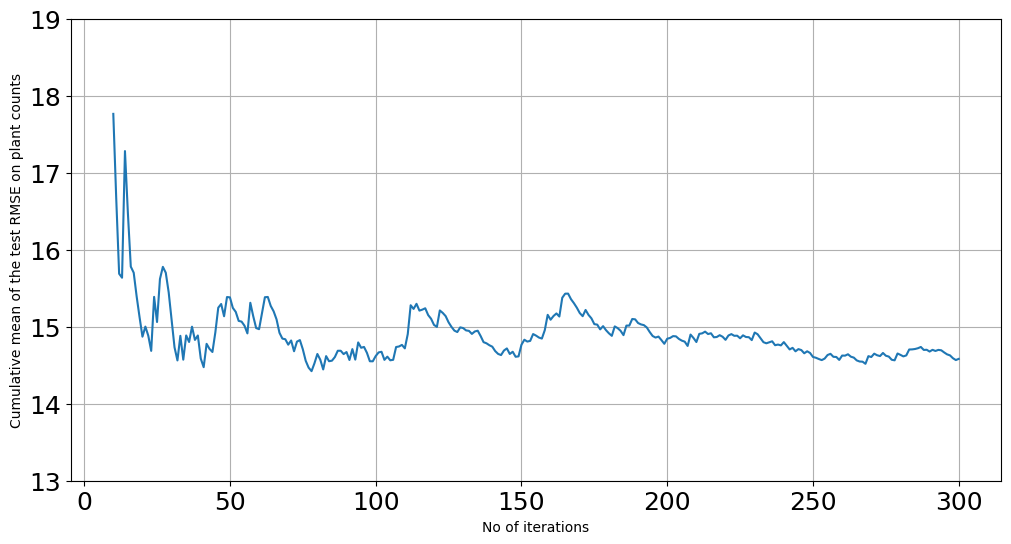

In [77]:
p70_np30_sampling_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative mean of the test RMSE on plant counts")
plt.xticks(range(0,301,50), fontsize = 18)
plt.yticks(range(13,20,1), fontsize = 18)
plt.ylim(13, 19)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

#### d. (Plant / Not_plant) ratio = 80:20 (D)

In [ ]:
p80_np20_sampling_480_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})
for seed in range(480):
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")
    annotation_images_to_be_sampled = annotations_sampling_with_specific_pnp_ratio(
        seed_no = seed, plant_annotations = os.listdir(plant_annotation_images_dir), 
        not_plant_annotations = os.listdir(not_plant_annotation_images_dir), 
        desired_sample_size = training_sample_size, plant_ratio = 0.8)

    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
     
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
        
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    p80_np20_sampling_480_iter_record_df.loc[len(p80_np20_sampling_480_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]


In [13]:
p80_np20_sampling_480_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/p80_np20_sampling_480_iter_record.csv", index = False)
# p80_np20_sampling_250_iter_record_df = pd.read_csv("sampling_outputs/ss100/p80_np20_sampling_250_iter_record.csv")
p80_np20_sampling_480_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,0.0,33.0,1.00,7.254883
1,1.0,6.0,0.80,26.907248
2,2.0,1.0,0.75,28.811456
3,3.0,33.0,1.00,4.683304
4,4.0,39.0,1.00,6.024948
...,...,...,...,...
55,475.0,14.0,0.90,28.617594
56,476.0,21.0,1.00,3.125167
57,477.0,1.0,0.75,28.811456
58,478.0,26.0,1.00,19.231918


In [15]:
p80_np20_sampling_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 481, 1):
    mean_of_test_RMSEs = p80_np20_sampling_480_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    p80_np20_sampling_cumulative_mean_test_RMSEs_df.loc[len(p80_np20_sampling_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

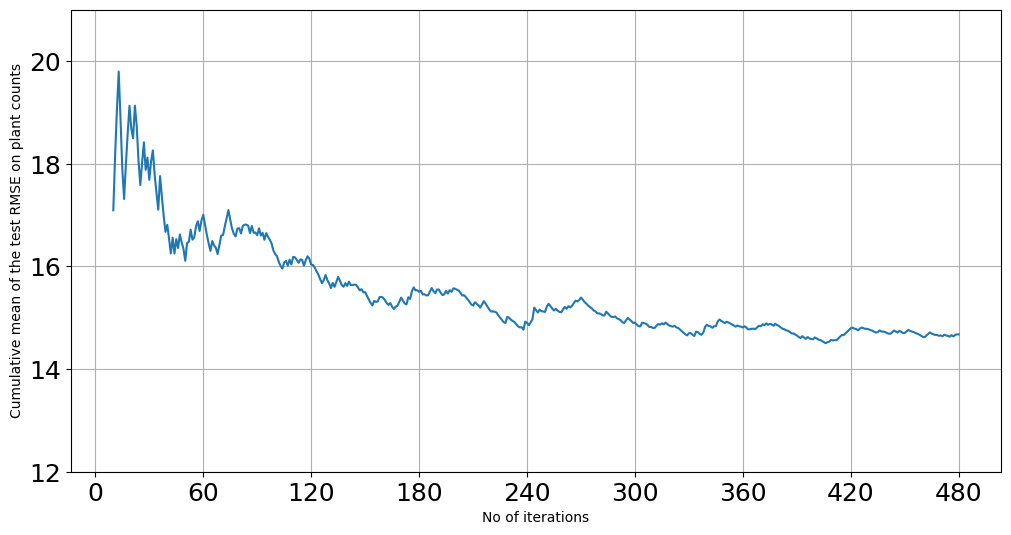

In [16]:
p80_np20_sampling_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative mean of the test RMSE on plant counts")
plt.xticks(range(0,481,60), fontsize = 18)
plt.yticks(range(12,22,2), fontsize = 18)
plt.ylim(12, 21)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

#### e. (Plant / Not_plant) ratio = 90:10 (D)

In [ ]:
p90_np10_sampling_390_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})
for seed in range(390):
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")
    annotation_images_to_be_sampled = annotations_sampling_with_specific_pnp_ratio(
        seed_no = seed, plant_annotations = os.listdir(plant_annotation_images_dir), 
        not_plant_annotations = os.listdir(not_plant_annotation_images_dir), 
        desired_sample_size = training_sample_size, plant_ratio = 0.9)

    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
     
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
        
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    p90_np10_sampling_390_iter_record_df.loc[len(p90_np10_sampling_390_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]


In [30]:
p90_np10_sampling_390_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/p90_np10_sampling_390_iter_record.csv", index = False)
# p90_np10_sampling_390_iter_record_df = pd.read_csv("sampling_outputs/ss100/p90_np10_sampling_390_iter_record.csv")
p90_np10_sampling_390_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,0.0,2.0,0.95,28.811456
1,1.0,1.0,0.95,28.811456
2,2.0,1.0,0.95,28.811456
3,3.0,21.0,1.00,9.235800
4,4.0,1.0,0.95,28.811456
...,...,...,...,...
385,385.0,17.0,1.00,2.732520
386,386.0,2.0,0.95,28.811456
387,387.0,1.0,0.95,28.811456
388,388.0,20.0,1.00,11.959654


In [20]:
p90_np10_sampling_390_iter_record_df = pd.read_csv("sampling_outputs/ss100/p90_np10_sampling_390_iter_record.csv")

In [21]:
p90_np10_sampling_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 391, 1):
    mean_of_test_RMSEs = p90_np10_sampling_390_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    p90_np10_sampling_cumulative_mean_test_RMSEs_df.loc[len(p90_np10_sampling_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

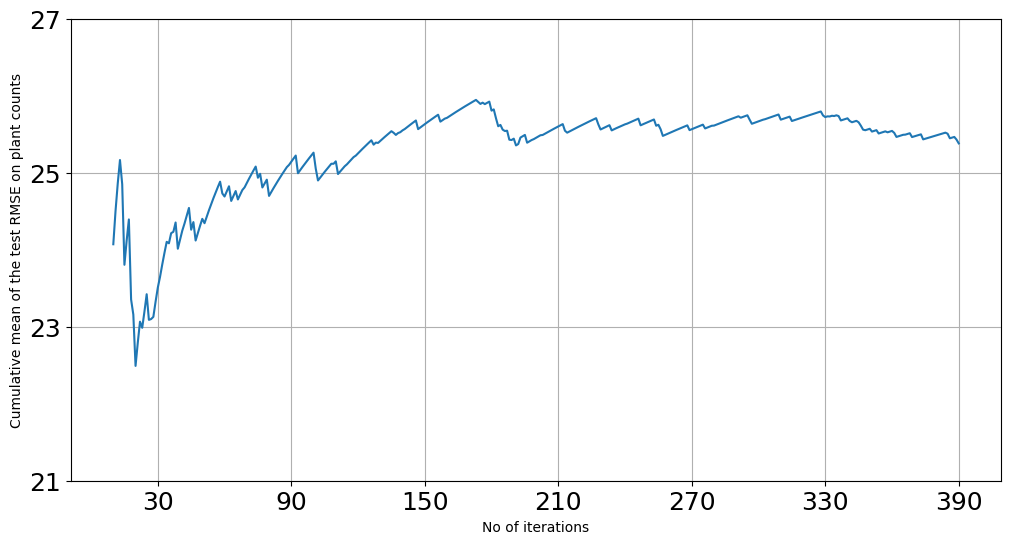

In [37]:
p90_np10_sampling_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative mean of the test RMSE on plant counts")
plt.xticks(range(30,391,60), fontsize = 18)
plt.yticks(range(21,28,2), fontsize = 18)
plt.ylim(21, 27)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

#### f. (Plant / Not_plant) ratio = 40:60 (D)

In [ ]:
p40_np60_sampling_130_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})
for seed in range(130, 200):
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")
    annotation_images_to_be_sampled = annotations_sampling_with_specific_pnp_ratio(
        seed_no = seed, plant_annotations = os.listdir(plant_annotation_images_dir), 
        not_plant_annotations = os.listdir(not_plant_annotation_images_dir), 
        desired_sample_size = training_sample_size, plant_ratio = 0.4)

    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
     
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
        
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    p40_np60_sampling_130_iter_record_df.loc[len(p40_np60_sampling_130_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]


In [33]:
p40_np60_sampling_130_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/p40_np60_sampling_130_iter_record_df.csv", index = False)
# p40_np60_sampling_130_iter_record_df = pd.read_csv("sampling_outputs/ss100/p40_np60_sampling_130_iter_record_df.csv")
p40_np60_sampling_130_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,0.0,19.0,1.0,3.371449
1,1.0,24.0,1.0,40.536815
2,2.0,36.0,1.0,26.264044
3,3.0,6.0,1.0,25.034643
4,4.0,23.0,1.0,45.117255
...,...,...,...,...
125,125.0,12.0,0.9,13.140269
126,126.0,34.0,1.0,23.497518
127,127.0,24.0,1.0,37.285833
128,128.0,19.0,1.0,44.962577


In [34]:
p40_np60_sampling_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 131, 1):
    mean_of_test_RMSEs = p40_np60_sampling_130_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    p40_np60_sampling_cumulative_mean_test_RMSEs_df.loc[len(p40_np60_sampling_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

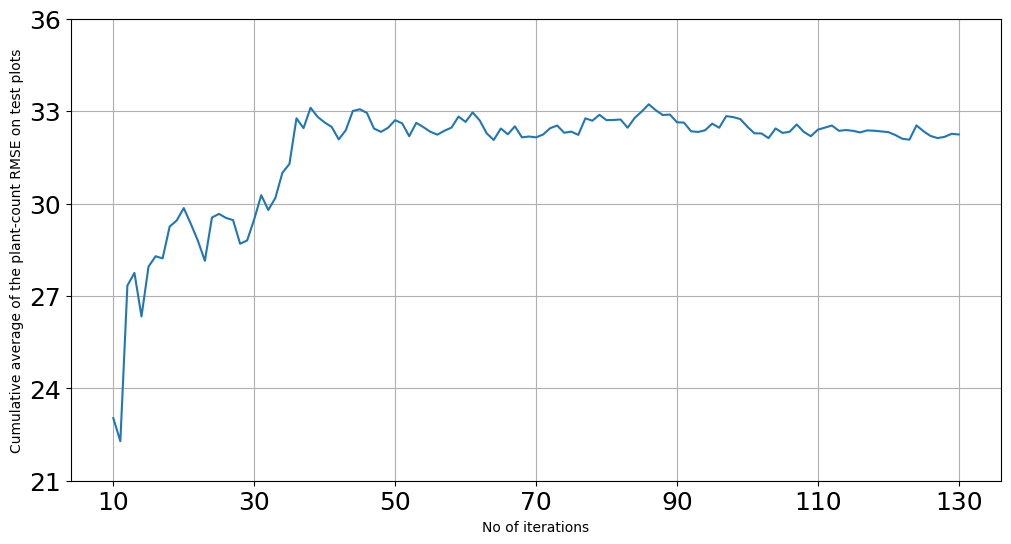

In [35]:
p40_np60_sampling_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative average of the plant-count RMSE on test plots")
plt.xticks(range(10,131,20), fontsize = 18)
plt.yticks(range(21,37,3), fontsize = 18)
plt.ylim(21, 36)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

#### g. (Plant / Not_plant) ratio = 30:70 (D)

In [ ]:
p30_np70_sampling_200_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})
for seed in range(200):
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")
    annotation_images_to_be_sampled = annotations_sampling_with_specific_pnp_ratio(
        seed_no = seed, plant_annotations = os.listdir(plant_annotation_images_dir), 
        not_plant_annotations = os.listdir(not_plant_annotation_images_dir), 
        desired_sample_size = training_sample_size, plant_ratio = 0.3)

    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
     
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
        
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    p30_np70_sampling_200_iter_record_df.loc[len(p30_np70_sampling_200_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]


In [21]:
p30_np70_sampling_200_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/p30_np70_sampling_200_iter_record.csv", index = False)
# p30_np70_sampling_200_iter_record_df = pd.read_csv("sampling_outputs/ss100/p30_np70_sampling_200_iter_record.csv")
p30_np70_sampling_200_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,0.0,22.0,1.00,34.128190
1,1.0,48.0,1.00,45.751867
2,2.0,17.0,1.00,39.279766
3,3.0,8.0,1.00,32.813107
4,4.0,23.0,1.00,21.295539
...,...,...,...,...
195,195.0,10.0,1.00,38.873727
196,196.0,9.0,0.95,57.558955
197,197.0,7.0,1.00,25.095816
198,198.0,5.0,0.95,39.966236


In [78]:
p30_np70_sampling_200_iter_record_df = pd.read_csv("sampling_outputs/ss100/p30_np70_sampling_200_iter_record.csv")

In [79]:
p30_np70_sampling_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 201, 1):
    mean_of_test_RMSEs = p30_np70_sampling_200_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    p30_np70_sampling_cumulative_mean_test_RMSEs_df.loc[len(p30_np70_sampling_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

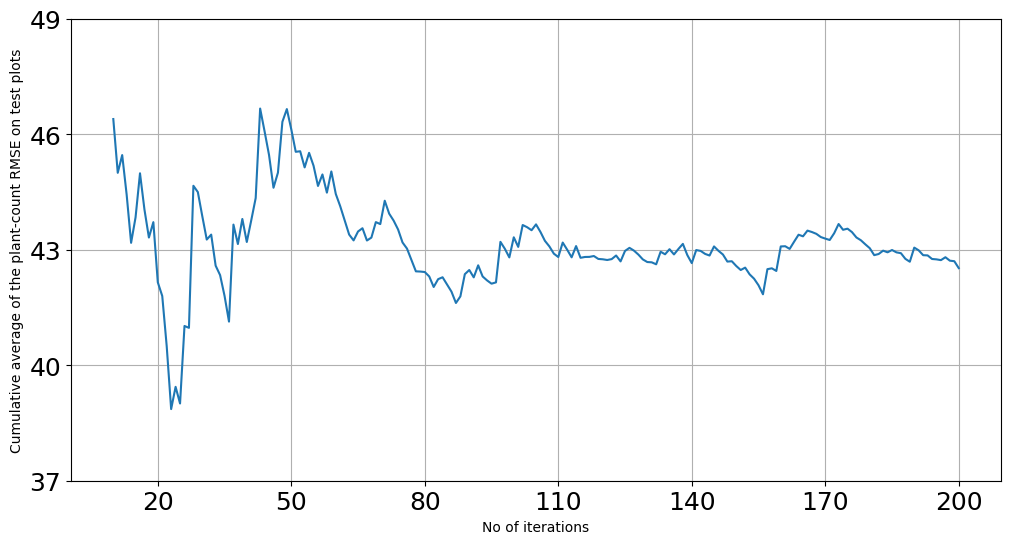

In [80]:
p30_np70_sampling_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative average of the plant-count RMSE on test plots")
plt.xticks(range(20,201,30), fontsize = 18)
plt.yticks(range(37,50,3), fontsize = 18)
plt.ylim(37, 49)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

#### h. (Plant / Not_plant) ratio = 20:80 (D)

In [ ]:
p20_np80_sampling_400_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})
for seed in range(350, 400):
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")
    annotation_images_to_be_sampled = annotations_sampling_with_specific_pnp_ratio(
        seed_no = seed, plant_annotations = os.listdir(plant_annotation_images_dir), 
        not_plant_annotations = os.listdir(not_plant_annotation_images_dir), 
        desired_sample_size = training_sample_size, plant_ratio = 0.2)

    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
     
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
        
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    p20_np80_sampling_400_iter_record_df.loc[len(p20_np80_sampling_400_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]


In [12]:
p20_np80_sampling_400_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/p20_np80_sampling_400_iter_record.csv", index = False)
# p20_np80_sampling_400_iter_record_df = pd.read_csv("sampling_outputs/ss100/p20_np80_sampling_400_iter_record.csv")
p20_np80_sampling_400_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,0.0,1.0,0.9,144.285827
1,1.0,36.0,1.0,55.228314
2,2.0,1.0,0.9,108.695906
3,3.0,1.0,0.9,144.285827
4,4.0,2.0,0.9,144.285827
...,...,...,...,...
395,395.0,2.0,0.9,144.285827
396,396.0,23.0,1.0,100.767554
397,397.0,26.0,1.0,75.023330
398,398.0,27.0,1.0,53.741976


In [13]:
p20_np80_sampling_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 401, 1):
    mean_of_test_RMSEs = p20_np80_sampling_400_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    p20_np80_sampling_cumulative_mean_test_RMSEs_df.loc[len(p20_np80_sampling_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

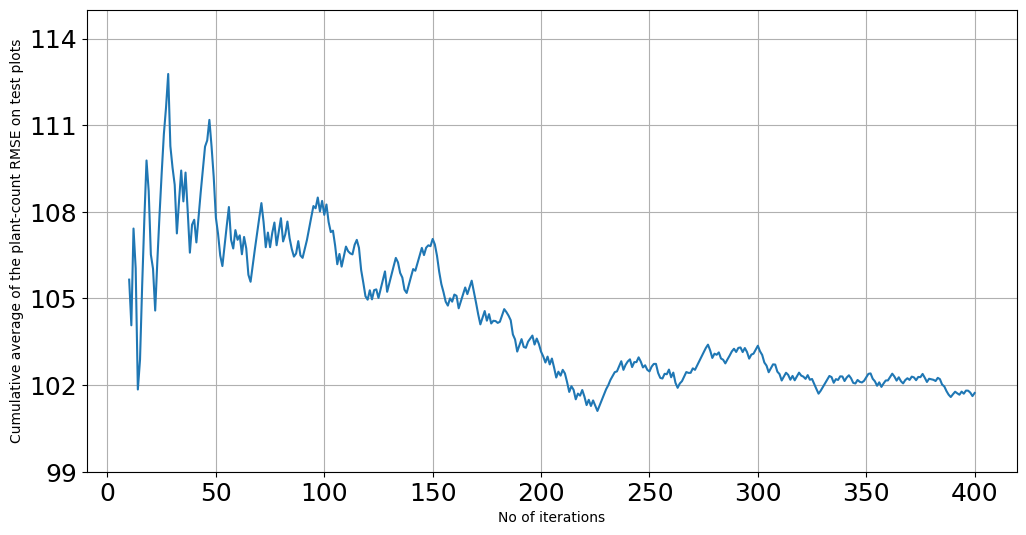

In [23]:
p20_np80_sampling_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative average of the plant-count RMSE on test plots")
plt.xticks(range(0,401,50), fontsize = 18)
plt.yticks(range(99,116,3), fontsize = 18)
plt.ylim(99, 115)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

#### i. (Plant/Not-plant) ratio = 10:90

In [ ]:
p10_np90_sampling_120_iter_record_df = pd.DataFrame({'seed': [], 'epoch_best': [], 'best_val_accuracy': [], 'RMSE_on_plant_count': []})
for seed in range(120):
    print("\n", "--- Iteration ", seed + 1, ":", sep = "")
    annotation_images_to_be_sampled = annotations_sampling_with_specific_pnp_ratio(
        seed_no = seed, plant_annotations = os.listdir(plant_annotation_images_dir), 
        not_plant_annotations = os.listdir(not_plant_annotation_images_dir), 
        desired_sample_size = training_sample_size, plant_ratio = 0.1)

    copy_selected_annot_images_to_sample_dir(images_sampled_dir = annot_images_sampled_dir, 
                                             plant_images_dir = plant_annotation_images_dir,
                                             not_plant_images_dir = not_plant_annotation_images_dir, 
                                             images_to_sample = annotation_images_to_be_sampled)
     
    model_epoch_best, model_best_val_acc = peatrain_work.run(
        annotation_images_dir = annot_images_sampled_dir, model_filename = "nnmodel.keras")
        
    current_iteration_plant_count_rmse = plant_count_rmse_calc(test_plots_directory = test_plots_dir)
    
    p10_np90_sampling_120_iter_record_df.loc[len(p10_np90_sampling_120_iter_record_df)] = [
        seed, model_epoch_best, model_best_val_acc, current_iteration_plant_count_rmse]


In [15]:
p10_np90_sampling_120_iter_record_df.to_csv(path_or_buf = "sampling_outputs/ss100/p10_np90_sampling_120_iter_record.csv", index = False)
# p10_np90_sampling_80_iter_record_df = pd.read_csv("sampling_outputs/ss100/p10_np90_sampling_80_iter_record.csv")
p10_np90_sampling_120_iter_record_df

,seed,epoch_best,best_val_accuracy,RMSE_on_plant_count
0,0.000,1.000,1.000,144.286
1,1.000,2.000,1.000,144.286
2,2.000,1.000,1.000,144.286
3,3.000,1.000,1.000,144.286
4,4.000,1.000,1.000,144.286
...,...,...,...,...
35,115.000,1.000,1.000,144.286
36,116.000,1.000,1.000,144.286
37,117.000,1.000,1.000,144.286
38,118.000,1.000,1.000,144.286


In [16]:
p10_np90_sampling_cumulative_mean_test_RMSEs_df = pd.DataFrame({'n_iter': [], 'cumulative_mean_of_test_RMSEs': []})
for head_n in range(10, 121, 1):
    mean_of_test_RMSEs = p10_np90_sampling_120_iter_record_df.head(head_n).mean()['RMSE_on_plant_count']
    p10_np90_sampling_cumulative_mean_test_RMSEs_df.loc[len(p10_np90_sampling_cumulative_mean_test_RMSEs_df)] = [head_n, mean_of_test_RMSEs]

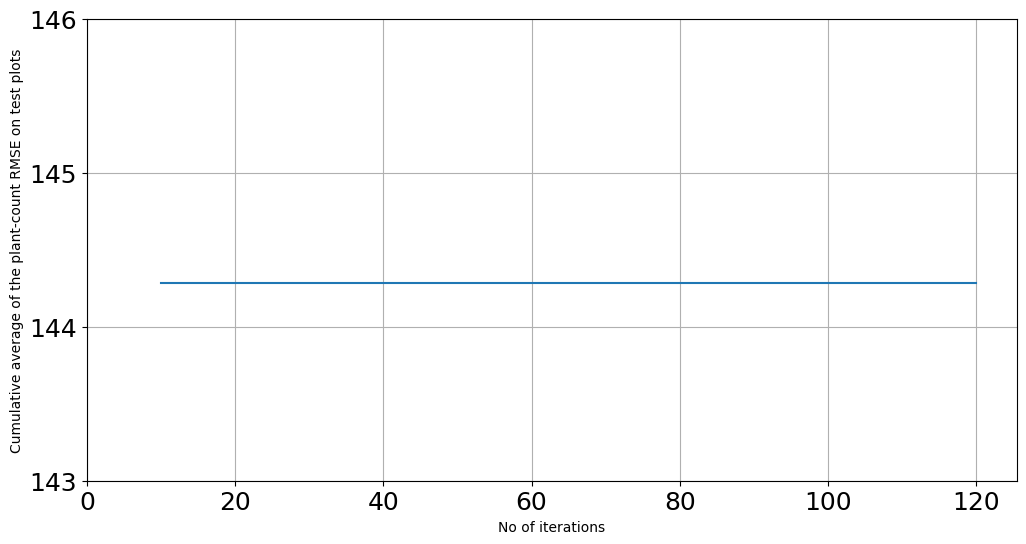

In [19]:
p10_np90_sampling_cumulative_mean_test_RMSEs_df.plot.line(figsize = (12, 6), x = 'n_iter', y = 'cumulative_mean_of_test_RMSEs')
plt.xlabel("No of iterations")
plt.ylabel("Cumulative average of the plant-count RMSE on test plots")
plt.xticks(range(0,121,20), fontsize = 18)
plt.yticks(range(143,147,1), fontsize = 18)
plt.ylim(143, 146)
plt.grid(axis = 'both')
plt.legend('', frameon = False)
plt.show()

In [ ]:
p10_np90_test_plots_plant_count_df = pd.DataFrame({'test_plot': [], 'model-made plant count': [], 'manual plant count': []})
for test_plot_filename in [item for item in os.listdir(test_plots_dir) if item.endswith(".png")]:
    current_test_plot_dir = set_up_for_peascription_on_each_test_plot(
        test_plots_dir = test_plots_dir, test_plot = test_plot_filename)

    peascription_work.run(in_dir_path = current_test_plot_dir, out_dir_path = current_test_plot_dir)

    current_test_plot_model_made_plant_count = count_plants_from_square_cutouts(current_test_plot_dir)

    p10_np90_test_plots_plant_count_df.loc[len(p10_np90_test_plots_plant_count_df)] = [
        test_plot_filename,
        current_test_plot_model_made_plant_count,
        len(os.listdir(os.path.join(current_test_plot_dir, "plant/")))]

p10_np90_test_plots_plant_count_df

2023-08-12 14:49:44.520676: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


,test_plot,model-made plant count,manual plant count
0,col1row56-orig.png,0,182
1,col12row21-orig.png,0,180
2,col1row69-orig.png,0,171
3,col4row71-orig.png,0,190
4,col6row36-orig.png,0,167
5,col9row22-orig.png,0,116
6,col3row59-orig.png,0,172
7,col2row14-orig.png,0,121
8,col3row45-orig.png,0,154
9,col3row70-orig.png,0,162


## Comparison of simulation results

In [2]:
srs_250_rmse = pd.read_csv('sampling_outputs/ss100/srs_250_iter_record.csv')['RMSE_on_plant_count']
sys_s_450_rmse = pd.read_csv('sampling_outputs/ss100/sys_s_450_iter_record.csv')['RMSE_on_plant_count']
p10_np90_sampling_120_rmse = pd.read_csv('sampling_outputs/ss100/p10_np90_sampling_120_iter_record.csv')['RMSE_on_plant_count']
p20_np80_sampling_400_rmse = pd.read_csv('sampling_outputs/ss100/p20_np80_sampling_400_iter_record.csv')['RMSE_on_plant_count']
p30_np70_sampling_200_rmse = pd.read_csv('sampling_outputs/ss100/p30_np70_sampling_200_iter_record.csv')['RMSE_on_plant_count']
p40_np60_sampling_130_rmse = pd.read_csv('sampling_outputs/ss100/p40_np60_sampling_130_iter_record_df.csv')['RMSE_on_plant_count']
p50_np50_sampling_310_rmse = pd.read_csv('sampling_outputs/ss100/p50_np50_sampling_310_iter_record.csv')['RMSE_on_plant_count']
p60_np40_sampling_500_rmse = pd.read_csv('sampling_outputs/ss100/p60_np40_sampling_500_iter_record.csv')['RMSE_on_plant_count']
p70_np30_sampling_300_rmse = pd.read_csv('sampling_outputs/ss100/p70_np30_sampling_300_iter_record.csv')['RMSE_on_plant_count']
p80_np20_sampling_480_rmse = pd.read_csv('sampling_outputs/ss100/p80_np20_sampling_480_iter_record.csv')['RMSE_on_plant_count']
p90_np10_sampling_390_rmse = pd.read_csv('sampling_outputs/ss100/p90_np10_sampling_390_iter_record.csv')['RMSE_on_plant_count']

sampling_method_rmse_dict = {'Simple Random Sampling': srs_250_rmse, 
                             'Systematic Sampling': sys_s_450_rmse, 
                             '10P:90NP Sampling': p10_np90_sampling_120_rmse, 
                             '20P:80NP Sampling': p20_np80_sampling_400_rmse, 
                             '30P:70NP Sampling': p30_np70_sampling_200_rmse, 
                             '40P:60NP Sampling': p40_np60_sampling_130_rmse, 
                             '50P:50NP Sampling': p50_np50_sampling_310_rmse, 
                             '60P:40NP Sampling': p60_np40_sampling_500_rmse, 
                             '70P:30NP Sampling': p70_np30_sampling_300_rmse, 
                             '80P:20NP Sampling': p80_np20_sampling_480_rmse, 
                             '90P:10NP Sampling': p90_np10_sampling_390_rmse}

In [5]:
sampling_compare = pd.DataFrame({'Mean plant-count RMSE': [], 'Std plant-count RMSE': [], 'Simulation length': []})

# Compute the mean and std of RMSe scores for each sampling method
sampling_compare.loc[len(sampling_compare)] = [srs_250_rmse.mean(), srs_250_rmse.std(), len(srs_250_rmse)]
sampling_compare.loc[len(sampling_compare)] = [sys_s_450_rmse.mean(), sys_s_450_rmse.std(), len(sys_s_450_rmse)]
sampling_compare.loc[len(sampling_compare)] = [p10_np90_sampling_120_rmse.mean(), p10_np90_sampling_120_rmse.std(), len(p10_np90_sampling_120_rmse)]
sampling_compare.loc[len(sampling_compare)] = [p20_np80_sampling_400_rmse.mean(), p20_np80_sampling_400_rmse.std(), len(p20_np80_sampling_400_rmse)]
sampling_compare.loc[len(sampling_compare)] = [p30_np70_sampling_200_rmse.mean(), p30_np70_sampling_200_rmse.std(), len(p30_np70_sampling_200_rmse)]
sampling_compare.loc[len(sampling_compare)] = [p40_np60_sampling_130_rmse.mean(), p40_np60_sampling_130_rmse.std(), len(p40_np60_sampling_130_rmse)]
sampling_compare.loc[len(sampling_compare)] = [p50_np50_sampling_310_rmse.mean(), p50_np50_sampling_310_rmse.std(), len(p50_np50_sampling_310_rmse)]
sampling_compare.loc[len(sampling_compare)] = [p60_np40_sampling_500_rmse.mean(), p60_np40_sampling_500_rmse.std(), len(p60_np40_sampling_500_rmse)]
sampling_compare.loc[len(sampling_compare)] = [p70_np30_sampling_300_rmse.mean(), p70_np30_sampling_300_rmse.std(), len(p70_np30_sampling_300_rmse)]
sampling_compare.loc[len(sampling_compare)] = [p80_np20_sampling_480_rmse.mean(), p80_np20_sampling_480_rmse.std(), len(p80_np20_sampling_480_rmse)]
sampling_compare.loc[len(sampling_compare)] = [p90_np10_sampling_390_rmse.mean(), p90_np10_sampling_390_rmse.std(), len(p90_np10_sampling_390_rmse)]

# Add a 95% confidence interval for each record
sampling_compare['95%CI Upper Bound'] = sampling_compare['Mean plant-count RMSE'] + 1.96 * (sampling_compare['Std plant-count RMSE'] / np.sqrt(sampling_compare['Simulation length']))
sampling_compare['95%CI Lower Bound'] = sampling_compare['Mean plant-count RMSE'] - 1.96 * (sampling_compare['Std plant-count RMSE'] / np.sqrt(sampling_compare['Simulation length']))

# Add the name of each sampling methods
sampling_compare['Sampling experiment'] = list(sampling_method_rmse_dict.keys())
sampling_compare = sampling_compare[['Sampling experiment', 'Mean plant-count RMSE', 'Std plant-count RMSE', 'Simulation length']]

# Sort the dataframe ascendingly according to the mean RMSE
sampling_compare = sampling_compare.sort_values('Mean plant-count RMSE', ascending = True).reset_index(drop = True)
sampling_compare

,Sampling experiment,Mean plant-count RMSE,Std plant-count RMSE,Simulation length,95%CI Upper Bound,95%CI Lower Bound
0,70P:30NP Sampling,14.582,9.833,300.000,15.695,13.470
1,80P:20NP Sampling,14.676,10.533,480.000,15.618,13.734
2,60P:40NP Sampling,21.052,14.071,500.000,22.285,19.818
3,50P:50NP Sampling,23.423,14.204,310.000,25.004,21.842
4,90P:10NP Sampling,25.381,7.195,390.000,26.095,24.667
5,40P:60NP Sampling,32.242,17.643,130.000,35.275,29.209
6,Systematic Sampling,37.566,20.711,450.000,39.480,35.653
7,Simple Random Sampling,41.076,32.737,250.000,45.134,37.018
8,30P:70NP Sampling,42.522,28.131,200.000,46.421,38.623
9,20P:80NP Sampling,101.726,41.370,400.000,105.780,97.672


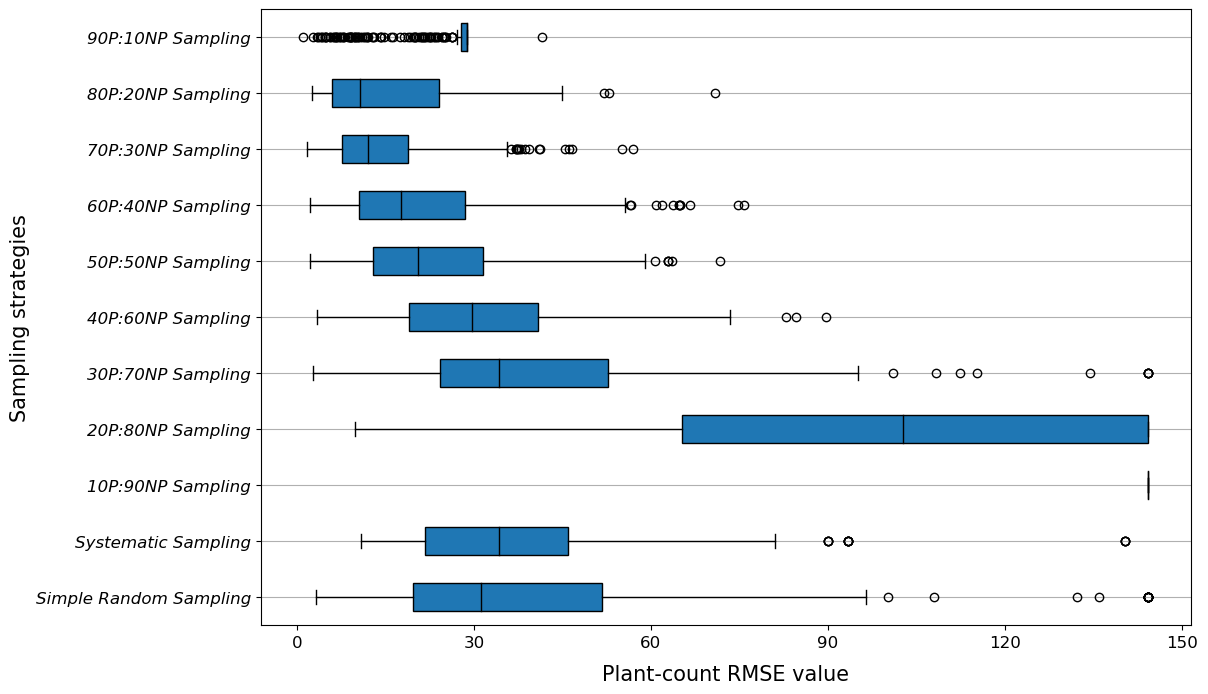

In [6]:
# Side-by-side box plots
plt.figure(figsize = (12, 8))
plt.boxplot(x = list(sampling_method_rmse_dict.values()), 
        labels = list(sampling_method_rmse_dict.keys()), widths = 0.5,
        patch_artist = True, medianprops = dict(color = 'black'), vert=False)
plt.xticks(range(0,151,30), fontsize = 12)
plt.yticks(fontsize = 12, fontstyle = 'italic')
plt.grid(visible = True, axis = 'y')
plt.xlabel("Plant-count RMSE value", fontdict = {'size': 15}, labelpad = 10)
plt.ylabel("Sampling strategies", fontdict = {'size': 15})
plt.show()

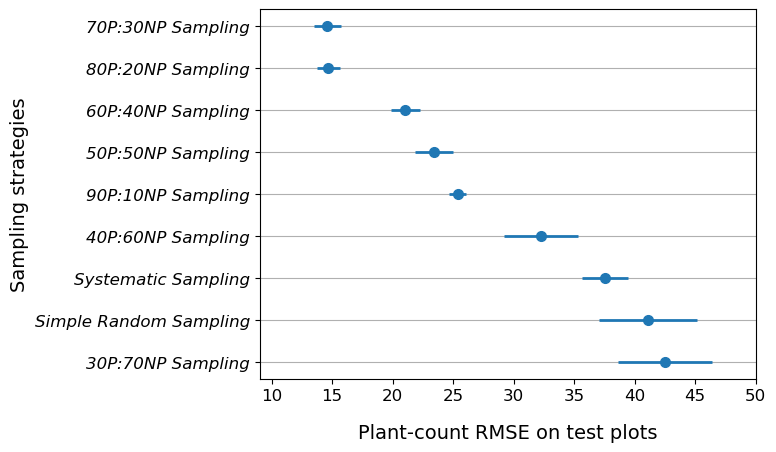

In [7]:
# Plotting the confidence intervals
plt.errorbar(x = sampling_compare[::-1][2:]['Mean plant-count RMSE'],
             y = sampling_compare[::-1][2:]['Sampling experiment'], 
             xerr = [sampling_compare[::-1][2:]['95%CI Upper Bound'] - sampling_compare[::-1][2:]['Mean plant-count RMSE'], 
                     sampling_compare[::-1][2:]['Mean plant-count RMSE'] - sampling_compare[::-1][2:]['95%CI Lower Bound']],
             fmt = 'o', elinewidth = 2, markersize = 7) 

plt.xlim(9,48)
plt.xticks(range(10,51,5), fontsize = 12)
plt.yticks(fontsize = 12, fontstyle = 'italic')
plt.ylabel("Sampling strategies", fontdict = {'size': 14})
plt.xlabel("Plant-count RMSE on test plots", fontdict = {'size': 14}, labelpad = 14)
plt.grid(visible = True, which = 'major', axis = 'y')

In [8]:
# Exporting all RMSE records to a CSV file for statistical tests in R
all_rmse_records = pd.DataFrame({'Sampling_strategy': [], 'Iteration_number': [], 'RMSE_score': []})
for sampling_method, rmse_records in sampling_method_rmse_dict.items():
    for iter_no, rmse_score in enumerate(rmse_records):
        all_rmse_records.loc[len(all_rmse_records)] = [sampling_method, iter_no + 1, rmse_score]

all_rmse_records.to_csv("Writing/supplementary/all_rmse_records.csv", index = False)

## Visualising the p-values returned by the post-hoc Dunn's test 

In [2]:
sampling_methods = ['10P:90NP Sampling', '20P:80NP Sampling', '30P:70NP Sampling', '40P:60NP Sampling', 
                    '50P:50NP Sampling', '60P:40NP Sampling', '70P:30NP Sampling', '80P:20NP Sampling', 
                    '90P:10NP Sampling', 'Simple Random Sampling', 'Systematic Sampling']

# Reading the CSV file of the Dunn's test results
dunn_test_with_holm_adj_df = pd.read_csv("Writing/supplementary/dunn_test.csv")

# Arranging the p-values in a dataframe that looks like a triangular confusion matrix
pairwise_p_values = pd.DataFrame(columns = sampling_methods, index = sampling_methods)
for index, row in dunn_test_with_holm_adj_df.iterrows():
    comparand_1, comparand_2 = row['Comparison'].split(" - ")
    pairwise_p_values.at[comparand_2, comparand_1] = row['P.adj']

pairwise_p_values.insert(0, "10P:90NP Sampling", pairwise_p_values.pop("10P:90NP Sampling"))

pairwise_p_values = pairwise_p_values.iloc[1:, :-1].astype('float64')

# Formatting the values to be displayed in a dataframe
pd.options.display.float_format = '{:.3g}'.format
pairwise_p_values

,10P:90NP Sampling,20P:80NP Sampling,30P:70NP Sampling,40P:60NP Sampling,50P:50NP Sampling,60P:40NP Sampling,70P:30NP Sampling,80P:20NP Sampling,90P:10NP Sampling,Simple Random Sampling
20P:80NP Sampling,0.0369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30P:70NP Sampling,1.56e-23,2.45e-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40P:60NP Sampling,1.62e-29,2.85e-29,0.135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50P:50NP Sampling,1.44e-69,1.52e-99,2.77e-14,0.0002,NaN,NaN,NaN,NaN,NaN,NaN
60P:40NP Sampling,3.16e-90,8.25e-151,4.56e-24,1.96e-08,0.281,NaN,NaN,NaN,NaN,NaN
70P:30NP Sampling,3.56e-113,5.61e-174,2.99e-42,7.67e-20,4.59e-10,9.82e-07,NaN,NaN,NaN,NaN
80P:20NP Sampling,1.28e-125,3.87e-219,7.93e-49,7.29e-22,6.69e-12,3.49e-08,0.885,NaN,NaN,NaN
90P:10NP Sampling,3.66e-56,5.24e-81,5.01e-07,0.251,0.0137,8.79e-08,3.09e-23,1.38e-28,NaN,NaN
Simple Random Sampling,1.65e-32,4.02e-37,0.472,0.856,5e-10,6.23e-19,8.45e-37,1.95e-43,0.000861,NaN
Systematic Sampling,3.12e-32,3.36e-41,1,0.205,1.61e-18,3.81e-35,3.44e-58,1.07e-73,1.12e-08,0.704


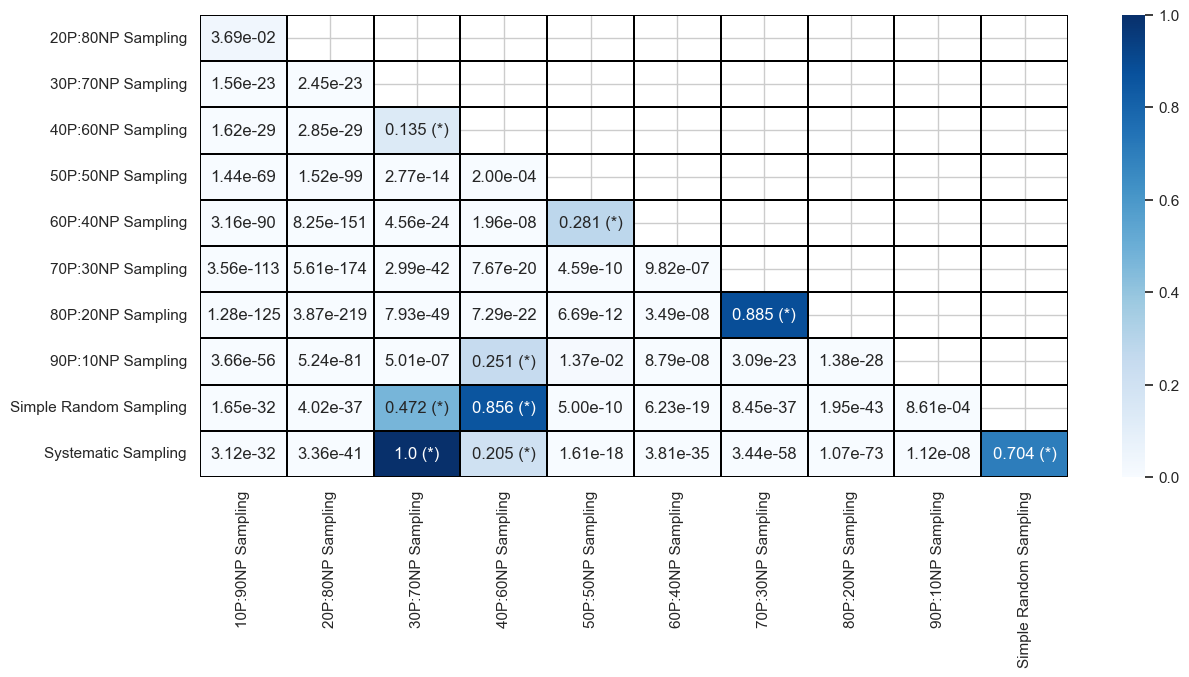

In [3]:
def denote_significance_in_data_text(data_value):
    if np.isnan(data_value):
        return np.nan
    elif data_value < 0.05:
        return '{:0.2e}'.format(data_value)
    else:
        return str(round(data_value, 3)) + " (*)"
     
# Visualising the pariwise p-values obtained from the Dunn's test in a heatmap
sns.set(rc = {'figure.figsize': (14, 6)})
sns.set_style("whitegrid")
sns.heatmap(pairwise_p_values, annot = pairwise_p_values.applymap(denote_significance_in_data_text), 
            fmt = '', cmap = "Blues", linewidths = 0.2, linecolor = 'black')
plt.show()